# Probabilistic Time Series Analysis

## Week 5: Recurrent Neural Networks (Part 2)

Places where you are supposed to fill in code are marked

    #
    # TODO: some instructions
    # 
    
You will need to install the PyTorch package. You can find instructions here that will generate a pip or conda command for you to run:

- https://pytorch.org/get-started/locally/

# Setup

In [2]:
# ! pip install --user torch

    100% |████████████████████████████████| 519.5MB 153kB/s ta 0:00:011    38% |████████████▍                   | 200.2MB 8.9MB/s eta 0:00:36    48% |███████████████▋                | 254.1MB 12.0MB/s eta 0:00:23    88% |████████████████████████████▏   | 457.2MB 12.4MB/s eta 0:00:06


In [3]:
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import string
import random
import time
import math

from tqdm import tqdm

%matplotlib inline

In [4]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = open(filename).read()
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [5]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [6]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

# Select Dataset

In [7]:
filename = '../../data/holmes.txt'

file, file_len = read_file(filename)

# Training

In [124]:
#
# Hyperparameters
#

model = 'lstm' #'gru' or 'lstm'
n_epochs = 1000
print_every = 50
hidden_size = 100
n_layers = 2
learning_rate = 1e-1
chunk_len = 150
batch_size = 40

params_dict = {'model' : model,
               'n_epochs' : n_epochs, 
               'hidden_size' : hidden_size, 
               'n_layers' : n_layers, 
               'learning_rate' : learning_rate, 
               'chunk_len' : chunk_len, 
               'batch_size' : batch_size}

params = ['model', 'n_epochs', 'hidden_size', 'n_layers', 'learning_rate', 'chunk_len', 'batch_size']

In [125]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        all_losses.append(loss)
        
        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=False))
            print('\n')
except e:
    print(e)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training for 1000 epochs...


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  5%|▌         | 50/1000 [00:53<24:18,  1.54s/it]

 53s (50 5%) 2.6448]
Whe in un to. jere. an in umee oWerant tupyecun tre. saye site pe cann Shy he ek pas on pof obs of oth




 10%|█         | 100/1000 [02:04<20:42,  1.38s/it]

 4s (100 10%) 2.4961]
Whigevepth fineleg red
buld on the ang. akasecy at, in onimcing noldiles shrumd misegrild ofred the so




 15%|█▌        | 150/1000 [03:13<20:20,  1.44s/it]

 12s (150 15%) 2.4283]
Who in he hace coterith wire prosdes anc ferted ins al shournint mer ha the montirsts birid tEn r eteo




 20%|██        | 200/1000 [04:12<15:34,  1.17s/it]

 12s (200 20%) 2.4084]
Whect pot hensllibed the in pard loden. Nisn andemton oetes sfevont wend sand hi, best ines hics en th




 25%|██▌       | 250/1000 [05:10<14:44,  1.18s/it]

 10s (250 25%) 2.4753]
What and the pace ved andrire as or non
bolres I   rot tefrearversed celre, ikexrled of heeme oas are 




 30%|███       | 300/1000 [06:09<13:28,  1.16s/it]

 9s (300 30%) 2.3241]
Whe nor of of ant aevent to he as has sentindhel Rolastister to lors to ind, of of he curlerand Vald h




 35%|███▌      | 350/1000 [07:11<14:16,  1.32s/it]

 11s (350 35%) 2.3877]
Wh at Eng and ant the on oousing he the thissin't arinsistisine brereseinacauut of ders in the he poum




 40%|████      | 400/1000 [08:13<11:42,  1.17s/it]

 13s (400 40%) 2.4302]
White bolan were tuds of cole of
-rusing eblir iled cifnolithever, red aly pring the lond, the the the




 45%|████▌     | 450/1000 [09:10<11:00,  1.20s/it]

 10s (450 45%) 2.3288]
Whagatserlels weand ling act of wang of adde the wocto by the cosacs the fif hocted arciam in so ca co




 50%|█████     | 500/1000 [10:08<10:40,  1.28s/it]

 8s (500 50%) 2.3663]
Whe stelelis peand ving beader the thaplalre sotentey loor he the whiNed alrt sindreas foll.
 ing the 




 55%|█████▌    | 550/1000 [11:07<08:56,  1.19s/it]

 7s (550 55%) 2.4079]
Whes
sodt here the whe at the wolis glomleclitiw) tored here seror of inty. tung ofmer!


mose. and th




 60%|██████    | 600/1000 [12:07<08:12,  1.23s/it]

 7s (600 60%) 2.3776]
WhE colweres here beot the theetantert efe sinned or for of aund of ale bery co Jighc ded ble in hang 




 65%|██████▌   | 650/1000 [13:11<07:25,  1.27s/it]

 11s (650 65%) 2.3340]
Whe thit in ardeg the tuy trat liuted
cated excifed the and biund of ans and and in. Whatiwn  to ere o




 70%|███████   | 700/1000 [14:14<06:19,  1.27s/it]

 14s (700 70%) 2.3868]
Whriboinsuviwn as gy highenk ablaone and all.
" the burittee for, the quv ber the to  veyey hiss on co




 75%|███████▌  | 750/1000 [15:17<05:22,  1.29s/it]

 17s (750 75%) 2.3140]
Whe jore proussed and wat fo anputed tor
a the of dog postud ppforging mame  

The in sard at whal, th




 80%|████████  | 800/1000 [16:20<04:15,  1.28s/it]

 20s (800 80%) 2.3335]
Whe whise ad he be leslucturecans the
extucare ded dor of ang it gatajere the and
linated ext ins the 




 85%|████████▌ | 850/1000 [17:25<03:17,  1.31s/it]

 25s (850 85%) 2.3128]
Whed cout it als the at that reca andey ansyy gy and cal,"" whe waratetey cout rat and remolittlemer a




 90%|█████████ | 900/1000 [18:30<02:11,  1.31s/it]

 29s (900 90%) 2.2817]
Wheile he of the dided alplarad heoult, thinengre presteamoven the on larton wanlere the aresarpieniti




 95%|█████████▌| 950/1000 [19:37<01:09,  1.40s/it]

 36s (950 95%) 2.3230]
Whfy. ar the flreged ale. as didg bess the that plardersim bitesed the of he undertlanritencopemor re 




100%|██████████| 1000/1000 [20:27<00:00,  1.05s/it]

 27s (1000 100%) 2.3284]
Why-Id ged erking am
retles.

"Whalpomugh dout
fay mis sage arlamis momary peom the Geing alst beratas




# Evaluation

In [87]:
# 
# TODO: The variable all_losses contains the per-epoch losses (these are longer time units than in the last lab).
# Plot these losses. Try changing the learning rate or other hyperparameters until you get different behavior, and
# plot those losses as well. What seems to affect the rate of decrease? Do you notice a difference from last time?
#

In [12]:
import numpy as np
import pandas as pd

## Params saving

In [126]:
params_dict['final_loss'] = all_losses[-1]
params_dict['all_losses'] = all_losses

In [160]:
# initializing eval_df

# eval_df = pd.DataFrame(columns=params + ['final_loss', 'all_losses'])

In [217]:
eval_df = eval_df.append(params_dict, ignore_index=True)
eval_df.sort_values(by=['model', 'learning_rate'], inplace=True)
eval_df.reset_index(drop=True, inplace=True)

In [219]:
# writing to csv file

# eval_df.to_csv('eval_df.csv')

In [232]:
# reading from csv file

def str_to_float(x):
    if type(x) == float:
        return x
    elif x[0] == 't':
        if x[-1] == ',':
            return float(x[7:-2])
        else:
            return float(x[7:-1])
    else:
        if x[-1] == ',':
            return float(x[:-1])
        else:
            return float(x)

eval_df = pd.read_csv('eval_df.csv', index_col=0)
eval_df.final_loss = eval_df.final_loss.apply(str_to_float)
eval_df.all_losses = eval_df.all_losses.apply(lambda x: [str_to_float(el) for el in x[1:-1].split()])

In [234]:
eval_df

,model,n_epochs,hidden_size,n_layers,learning_rate,chunk_len,batch_size,final_loss,all_losses
0,gru,1000,100,2,0.001,150,40,1.722400,"[4.6367, 4.5918, 4.5429, 4.4928, 4.4436, 4.379..."
1,gru,1000,100,2,0.005,150,40,1.572700,"[4.5958, 4.326, 3.8635, 3.4169, 3.2148, 3.1517..."
2,gru,1000,100,2,0.010,150,40,1.557401,"[4.607749, 4.055163, 3.3172934, 3.2578216, 3.0..."
3,gru,1000,100,2,0.100,150,40,2.216300,"[4.6237, 5.4039, 3.8692, 5.7267, 4.6817, 4.968..."
4,lstm,1000,100,2,0.005,150,40,1.692400,"[4.6038, 4.4739, 4.121, 3.6058, 3.3124, 3.1668..."
5,lstm,1000,100,2,0.010,150,40,1.583200,"[4.5937, 4.3674, 3.5718, 3.2284, 3.1854, 3.204..."
6,lstm,1000,100,2,0.100,150,40,2.328400,"[4.5813, 3.6054, 4.4298, 3.5533, 4.0493, 3.262..."


## Different learning rates (gru)

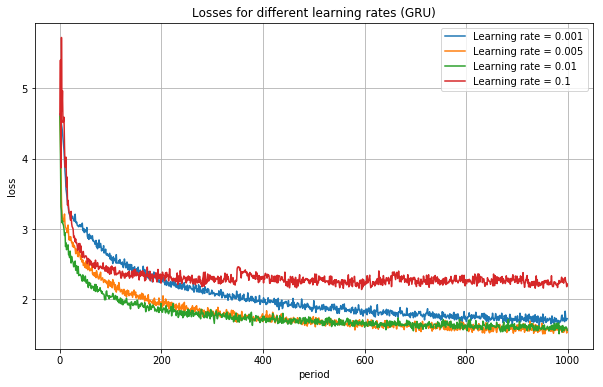

In [235]:
all_losses = np.array(eval_df.all_losses[0])
x = np.arange(0, all_losses.shape[0])

plt.figure(figsize=(10,6))
for i in [0, 1, 2, 3]:
    plt.plot(x, eval_df.all_losses[i], 
             label='Learning rate = '+str(round(eval_df.learning_rate[i], 4)))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different learning rates (GRU)')
plt.legend()

plt.grid()
plt.show()

## Different learning rates (lstm)

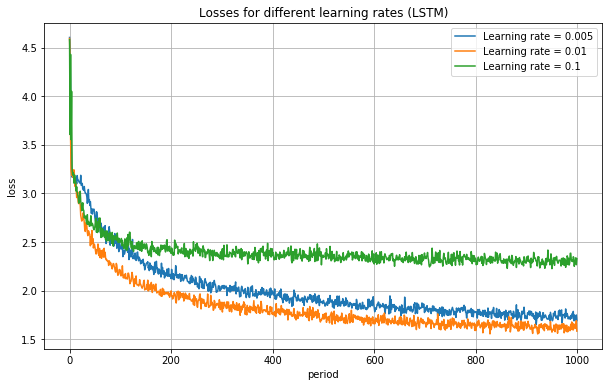

In [236]:
all_losses = np.array(eval_df.all_losses[0])
x = np.arange(0, all_losses.shape[0])

plt.figure(figsize=(10,6))
for i in [4, 5, 6]:
    plt.plot(x, eval_df.all_losses[i], 
             label='Learning rate = '+str(round(eval_df.learning_rate[i], 4)))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different learning rates (LSTM)')
plt.legend()

plt.grid()
plt.show()

## GRU vs LSTM

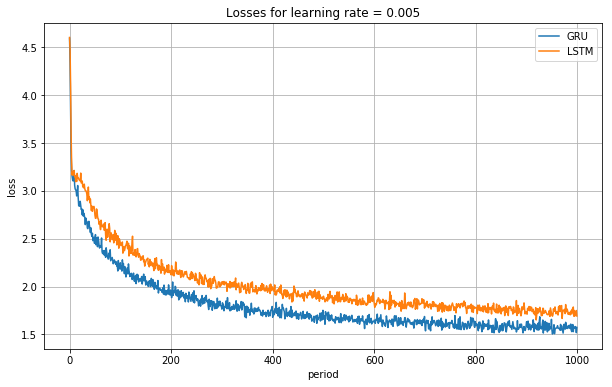

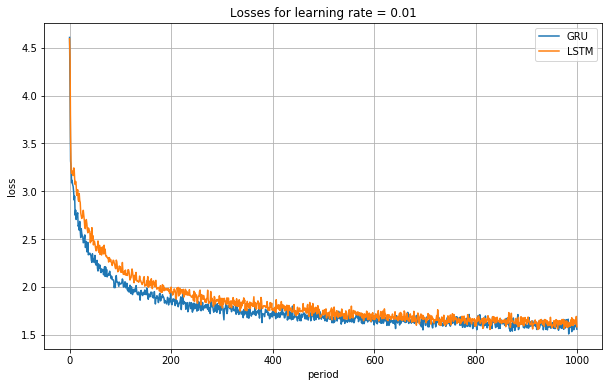

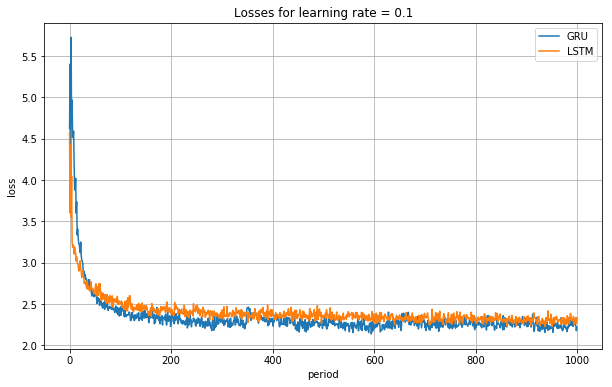

In [250]:
all_losses = np.array(eval_df.all_losses[0])
x = np.arange(0, all_losses.shape[0])

for lr in [0.005, 0.01, 0.1]:

    plt.figure(figsize=(10,6))
    plt.plot(x, eval_df[((eval_df.learning_rate == lr) & (eval_df.model == 'gru'))].all_losses.values[0], 
             label='GRU')
    plt.plot(x, eval_df[((eval_df.learning_rate == lr) & (eval_df.model == 'lstm'))].all_losses.values[0], 
             label='LSTM')
    plt.xlabel('period')
    plt.ylabel('loss')
    plt.title('Losses for learning rate = '+str(lr))
    plt.legend()

    plt.grid()
    plt.show()

In [ ]:
# def PlotResultsChangeLearningRate(title):
#     global all_losses, learning_rate
#     all_losses = np.array(all_losses)
#     # lrates = np.array(lrates)
#     x = np.arange(0, all_losses.shape[0])

#     fig, ax1 = plt.subplots(figsize=(10,6))
#     ax2 = ax1.twinx()

#     ax1.plot(x, all_losses, 'g', label='all losses')
#     ax2.hlines(learning_rate, x[0], x[-1], 'r', label='learning rate')
#     ax1.set_xlabel('period')
#     ax1.set_ylabel('loss', color='g')
#     ax2.set_ylabel('learning rate', color='r')
#     ax1.set_title(title)
#     ax1.legend()

#     ax1.grid()
#     plt.show()

# Sampling

In [ ]:
#
# TODO: Here is an example of sampling from the trained network. The parameter `temperature` can
# be tuned to vary the probability distribution from which we sample, like before.
# Pass in different values and print a few samples with each. What's the difference?
# Do you notice a difference in quality for the same text with similar hyperparameters
# between the LSTM / GRU and the naive implementation from last week?
#

# Example of sampling:
print generate(decoder, prime_str='A', predict_len=200, temperature=0.2)

In [ ]:
#
# TODO: You can also make the `prime_str` parameter longer. Try making it a word or phrase and see if the completion
# is reasonable.
#

# References

This code is based on the following Python package:

- https://github.com/spro/char-rnn.pytorch